# OCA FLAT Files Scan and Analysis

In [122]:
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

from pathlib import Path

from tqdm import tqdm
from astropy.io import fits
from astropy.coordinates import EarthLocation, AltAz, get_sun
from astropy.time import Time

import numpy as np

import polars as pl

from rich.progress import Progress

## Config

In [123]:
base_dir = '~/data/fits'
telescopes = ['zb08', 'wk06', 'jk15']

tel = 'jk15'

observatory = EarthLocation.of_site('OCA')
all_flat_file = Path(f"{tel}_all_flat_file_stats.parquet")


Directories

In [124]:
flats_dir = Path(base_dir).expanduser() / Path(tel) / Path('processed-ofp/flats')


In [125]:
filters = [f.name for f in flats_dir.glob('*')]
print('Recognized filters:', filters)

Recognized filters: ['empty', 'i', 'z', 'Ha_w', 'u_s', 'Ic', 'b_s', 'B', 'V', 'g', 'v_s', 'y_s', 'r', 'u']


In [ ]:
rebuild = False # Set to True to rebuild the stats not using existing all_flat_file

if all_flat_file.exists() and not rebuild:
    stats_df = pl.read_parquet(all_flat_file)
    files_in_stats = set(stats_df['file'].to_list())
    print(f'Loaded {len(stats_df)} records from {all_flat_file}')
else:
    stats_df = pl.DataFrame(schema={
        "filter": pl.Utf8,
        "file": pl.Utf8,
        "exptime": pl.Float64,
        "date-obs": pl.Datetime,
        "sun-alt": pl.Float64,
        "mean": pl.Float64,
        "median": pl.Float64,
        "std": pl.Float64,
        "min": pl.Float64,
        "max": pl.Float64,
        "min-05": pl.Float64,
        "max-95": pl.Float64,
        "mean-central-90": pl.Float64,
        "read-mod": pl.Int64,
        "gain-mod": pl.Int64,
        "flat-era": pl.Int64,
        "test": pl.Int64,
        "bitpix": pl.Int64,
    })
    files_in_stats = set()

# collect all paths
all_paths = []
for f in tqdm(filters, desc="Collecting paths of FLATS for each filter", unit="filter"):
    paths = list((flats_dir / Path(f)).glob(f'*/{tel}?_????_?????.fits'))
    paths = [p for p in paths if p.name not in files_in_stats]
    all_paths.extend(paths)

print(f'Found {len(all_paths)} FITS files')

missing_files = []
for p in tqdm(all_paths, desc="Processing FLATS", unit="plik"):
    try:
        with fits.open(p) as hdul:
            hdu = hdul[0]
            date_obs = Time(hdu.header['DATE-OBS'], format='isot', scale='utc')
            altaz_frame = AltAz(obstime=date_obs, location=observatory)
            lower, upper = np.percentile(hdu.data, [5, 95])

            # Tworzenie nowego wiersza danych
            row = pl.DataFrame([{
                'filter': hdu.header['FILTER'],
                'file': p.name,
                'exptime': hdu.header['EXPTIME'],
                'date-obs': date_obs.to_datetime(),
                'sun-alt': get_sun(date_obs).transform_to(altaz_frame).alt.deg,
                'mean': hdu.data.mean(),
                'median': np.median(hdu.data),
                'std': hdu.data.std(),
                'min': float(hdu.data.min()),
                'max': float(hdu.data.max()),
                'min-05': float(lower),
                'max-95': float(upper),
                'mean-central-90': np.mean(hdu.data[(hdu.data > lower) & (hdu.data < upper)]),
                'read-mod': hdu.header['READ-MOD'],
                'gain-mod': hdu.header['GAIN-MOD'],
                'flat-era': hdu.header.get('FLAT-ERA', 0),
                'test': hdu.header.get('TEST', 0),
                'bitpix': hdu.header['BITPIX'],
            }])

            # Append the new row to the stats dataframe
            stats_df = pl.concat([stats_df, row], how='vertical')
    except Exception as e:
        missing_files.append((p, e))
print(f'Processed {len(all_paths) - len(missing_files)} files, {len(missing_files)} missing')


Loaded 1246 records from jk15_all_flat_file_stats.parquet


In [117]:
stats_df.write_parquet(all_flat_file)
print(f'All flat files stats saved to {all_flat_file}, {len(stats_df)} records')

All flat files stats saved to jk15_all_flat_file_stats.parquet, 1246 records


In [118]:
print(f'Readaot modees used: {stats_df["read-mod"].value_counts()}')

Readaot modees used: shape: (3, 2)
┌──────────┬───────┐
│ read-mod ┆ count │
│ ---      ┆ ---   │
│ i64      ┆ u32   │
╞══════════╪═══════╡
│ 2        ┆ 786   │
│ 5        ┆ 435   │
│ 4        ┆ 25    │
└──────────┴───────┘


In [119]:
read_mode = 2

In [120]:
stats_df = stats_df.with_columns(
    ((stats_df['mean-central-90'] - 0) / stats_df['exptime']).alias("speed")
)

In [121]:
import plotly.express as px
import numpy as np
import polars as pl
from scipy.optimize import curve_fit

# Exponential fit function
def exp_fit(x, a, b):
    return a * np.exp(b * x)

# Filter parameters
adu = [15000, 35000]

# Filter dataset
filtered_data = stats_df.filter(
    (stats_df['sun-alt'] >= -10) &
    (stats_df['sun-alt'] <= 2) &
    (stats_df['read-mod'] == read_mode) &
    (stats_df['mean-central-90'] >= adu[0]) &
    (stats_df['mean-central-90'] < adu[1])
)

# Separate morning and evening
morning_conditions = (filtered_data['date-obs'].dt.hour().is_between(3, 9, closed="both"))
morning_data = filtered_data.filter(morning_conditions).sort("sun-alt").to_pandas()
evening_data = filtered_data.filter(~morning_conditions).sort("sun-alt").to_pandas()

# Plotting function
def plot_with_fit(data, title):
    fig = px.scatter(
        data,
        x="sun-alt",
        y="speed",
        color="filter",
        hover_data=["file", "exptime", "read-mod", "gain-mod", "date-obs"],
        title=title,
        labels={"sun-alt": "Sun Altitude (deg)", "speed": "ADU/s"},
        log_y=True,  # Logarithmic scale
        opacity=0.3,  # Background points
    )

    # Add exponential fit lines for each filter
    for filt in data["filter"].unique():
        filt_data = data[data["filter"] == filt]

        if len(filt_data) > 2:  # Fit only if enough points
            # Exponential fit
            popt, _ = curve_fit(exp_fit, filt_data["sun-alt"], filt_data["speed"], maxfev=10000)
            fit_x = np.linspace(filt_data["sun-alt"].min(), filt_data["sun-alt"].max(), 100)
            fit_y = exp_fit(fit_x, *popt)

            # Add fitted line
            fig.add_scatter(
                x=fit_x, y=fit_y, mode="lines", name=f"{filt} fit",
                line=dict(color=px.colors.qualitative.Plotly[data["filter"].unique().tolist().index(filt)], width=2),
                opacity=1.0
            )

    fig.show()

# Generate plots for morning and evening
for label, data in [("Morning", morning_data), ("Evening", evening_data)]:
    plot_with_fit(data, f"ADU/s vs Sun Altitude ({label}, read-mod={read_mode})")

IndexError: list index out of range

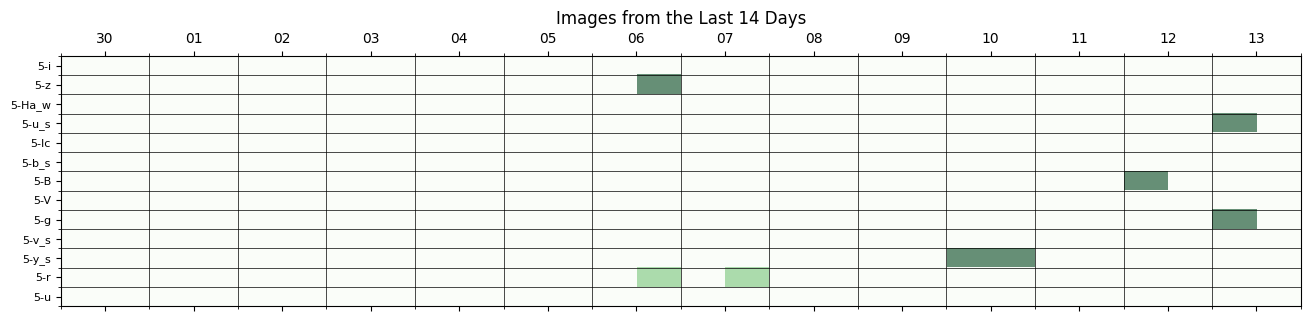

In [106]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta, timezone

# Ustawienia czasu i parametrów
threshold = 7
days_back = 14
end_date = datetime.now(timezone.utc).replace(hour=23, minute=59, second=59, microsecond=0).replace(tzinfo=None)
start_date = end_date - timedelta(days=days_back - 1)

# Definicja filtrów i trybów odczytu
show_read_modes = [read_mode]
show_filters = [f for f in filters if f != 'empty']
time_periods = ['Morning', 'Evening']

# Przygotowanie etykiet osi pionowej
y_labels = [f"{mode}-{filt}" for mode in show_read_modes for filt in show_filters]

# Filtrowanie danych z ostatnich 14 dni
last_two_weeks = stats_df.filter(
    (pl.col("date-obs") >= start_date) & (pl.col("date-obs") <= end_date)
)

# Dodanie kolumn dla pory dnia i daty obserwacji
last_two_weeks = last_two_weeks.with_columns([
    (
            (pl.col("date-obs").dt.hour().is_between(21, 23)) |
            (pl.col("date-obs").dt.hour().is_between(0, 3))
    ).alias("evening"),
    pl.col("date-obs").dt.truncate("1d").alias("obs-date")
])

# Agregacja danych
grouped_data = last_two_weeks.group_by(
    ["read-mod", "filter", "evening", "obs-date"]
).agg(
    pl.count("file").alias("counts")
)

# Przygotowanie osi X (Bieżący dzień włącznie)
x_labels = []
x_label_ticks = []
for i in range(days_back):
    day_label = (start_date + timedelta(days=i)).strftime('%d')
    x_labels.extend([f"{day_label}-M", f"{day_label}-E"])
    x_label_ticks.append((2 * i) + 0.5)

# Przygotowanie danych do wykresu
heatmap_data = np.zeros((len(y_labels), len(x_labels)))

# Wypełnianie macierzy
for row in grouped_data.iter_rows():
    mod, filt, eve, date_obs, count = row
    if mod in show_read_modes and filt in show_filters:
        y_label = f"{mod}-{filt}"
        if y_label in y_labels:
            y_idx = y_labels.index(y_label)
            day_idx = date_obs.strftime('%d')
            period = 'E' if eve else 'M'

            # Obsługa błędów
            if f"{day_idx}-{period}" not in x_labels:
                print(f"Warning: Missing label {day_idx}-{period}")
                continue

            x_idx = x_labels.index(f"{day_idx}-{period}")
            if count >= threshold:
                heatmap_data[y_idx, x_idx] = 0.6  # Jaśniejszy zielony (mniej ciemny)
            elif count > 0:
                heatmap_data[y_idx, x_idx] = 0.3  # Kropka

# Tworzenie wykresu
fig, ax = plt.subplots(figsize=(16, len(show_filters) / 4))  # Zmniejszenie osi Y
cax = ax.matshow(heatmap_data, cmap="Greens", aspect="auto", alpha=0.6)

# Dodanie etykiet osi
ax.set_xticks(x_label_ticks)
ax.set_xticklabels([(start_date + timedelta(days=i)).strftime('%d') for i in range(days_back)])

ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels, fontsize=8)

# Dodanie siatki między różnymi filtrami
ax.set_xticks(np.arange(-.5, len(x_labels), 2), minor=True)
ax.set_yticks(np.arange(-.5, len(y_labels), 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

# Pasek kolorów
# fig.colorbar(cax, ticks=[0, 0.5, 1.0], label="Images")

plt.title("Images from the Last 14 Days")
plt.show()

In [105]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta, timezone

# Time settings and parameters
threshold = 7
days_back = 14
end_date = datetime.now(timezone.utc).replace(tzinfo=None)
start_date = end_date - timedelta(days=days_back)

# Define filters and read modes
show_read_modes = [read_mode]
show_filters = [f for f in filters if f != 'empty']
time_periods = ['Morning', 'Evening']

# Prepare Y-axis labels
y_labels = [f"{mode}-{filt}" for mode in show_read_modes for filt in show_filters]

# Filter data from the last 14 days
last_two_weeks = stats_df.filter(
    (pl.col("date-obs") >= start_date) & (pl.col("date-obs") <= end_date)
)

# Add columns for observation date and time period
last_two_weeks = last_two_weeks.with_columns([
    (
            (pl.col("date-obs").dt.hour().is_between(21, 23)) |
            (pl.col("date-obs").dt.hour().is_between(0, 3))
    ).alias("evening"),
    pl.col("date-obs").dt.truncate("1d").alias("obs-date")
])

# Aggregate data
grouped_data = last_two_weeks.group_by(
    ["read-mod", "filter", "evening", "obs-date"]
).agg(
    pl.count("file").alias("counts")
)

# Prepare X-axis labels
x_labels = []
x_label_ticks = []
for i in range(days_back):
    day_label = (start_date + timedelta(days=i)).strftime('%d')
    x_labels.extend([f"{day_label}-M", f"{day_label}-E"])
    x_label_ticks.append((2 * i) + 0.5)

# Prepare data for the heatmap
heatmap_data = np.zeros((len(y_labels), len(x_labels)))

# Fill the heatmap matrix
for row in grouped_data.iter_rows():
    mod, filt, eve, date_obs, count = row
    if mod in show_read_modes and filt in show_filters:
        y_label = f"{mod}-{filt}"
        if y_label in y_labels:
            y_idx = y_labels.index(y_label)
            day_idx = date_obs.strftime('%d')
            period = 'E' if eve else 'M'
            x_idx = x_labels.index(f"{day_idx}-{period}")
            if count >= threshold:
                heatmap_data[y_idx, x_idx] = 0.6  # Brighter green
            elif count > 0:
                heatmap_data[y_idx, x_idx] = 0.3  # Dot

# Create the plot
fig, ax = plt.subplots(figsize=(16, len(show_filters) / 4))  # Adjust Y-axis size
cax = ax.matshow(heatmap_data, cmap="YlGn", aspect="auto", alpha=0.6)

# Add X-axis labels
ax.set_xticks(x_label_ticks)
ax.set_xticklabels([(start_date + timedelta(days=i)).strftime('%d') for i in range(days_back)])

# Add Y-axis labels on the right side
ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels, fontsize=8)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# Add grid between filters
ax.set_xticks(np.arange(-.5, len(x_labels), 2), minor=True)
ax.set_yticks(np.arange(-.5, len(y_labels), 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

# Color bar
fig.colorbar(cax, ticks=[0, 0.3, 0.6], label="Images")

plt.title("Images from the Last 14 Days")
plt.show()

ValueError: '13-M' is not in list